Dataset yang digunakan "Germany electricity power for 2006-2017"

[Dataset](https://www.kaggle.com/mvianna10/germany-electricity-power-for-20062017) 

In [84]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [85]:
data_train = pd.read_csv('/content/opsd_germany_daily.csv')
data_train

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


In [86]:
dates = data_train['Date'].values
consumption  = data_train['Consumption'].values

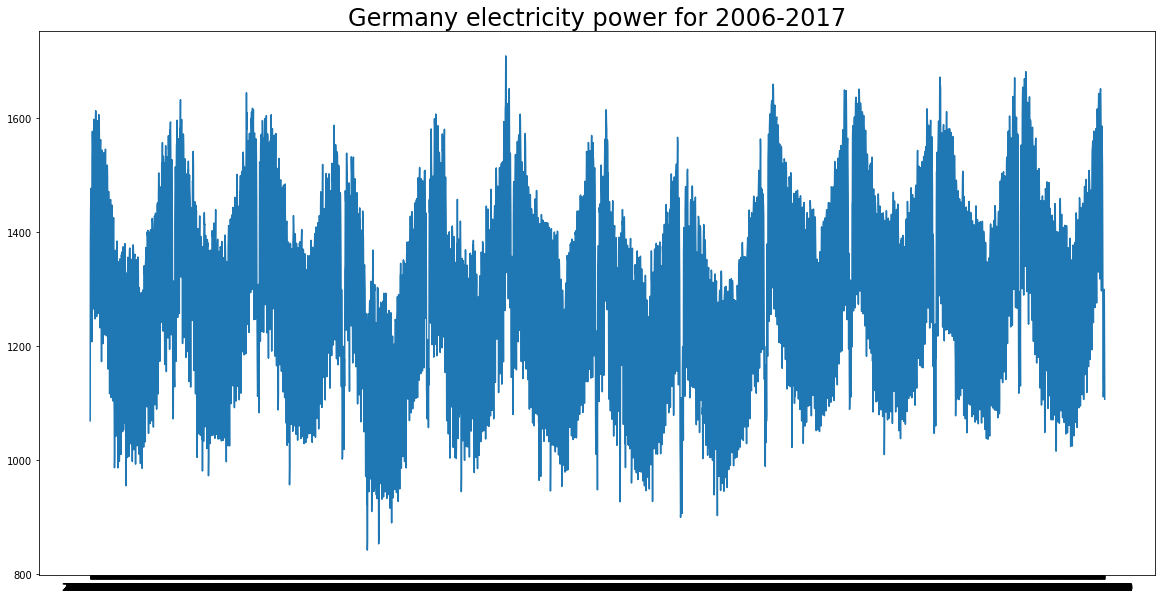

In [88]:
plt.figure(figsize=(20,10))
plt.plot(dates, consumption)
plt.title('Germany electricity power for 2006-2017',
          fontsize=24);

In [89]:
x_train, x_test, y_train, y_test = train_test_split(dates, consumption, test_size=0.2, random_state=42, shuffle=False)

In [90]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [91]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<300):
      print("\nMae telah mencapai dibawah 10% dari data!")
      self.model.stop_training = True
callbacks = myCallback()

In [92]:
train_set = windowed_dataset(y_train, window_size=30, batch_size=30, shuffle_buffer=380)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.LSTM(30),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(15, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [94]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100, callbacks=[callbacks])

Epoch 1/100
116/116 [==============================] - 6s 17ms/step - loss: 1326.0959 - mae: 1326.5959
Epoch 2/100
116/116 [==============================] - 2s 17ms/step - loss: 1325.6283 - mae: 1326.1283
Epoch 3/100
116/116 [==============================] - 2s 17ms/step - loss: 1324.2042 - mae: 1324.7042
Epoch 4/100
116/116 [==============================] - 2s 17ms/step - loss: 1313.8041 - mae: 1314.3041
Epoch 5/100
116/116 [==============================] - 2s 17ms/step - loss: 514.4228 - mae: 514.9224
Epoch 6/100
116/116 [==============================] - 2s 17ms/step - loss: 145.2860 - mae: 145.7850

Mae telah mencapai dibawah 10% dari data!


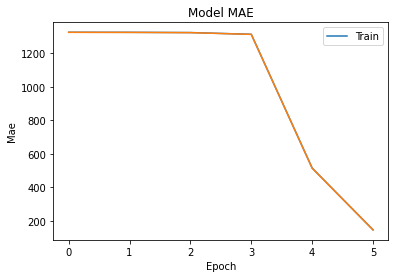

In [99]:
plt.plot(history.history['mae'])
plt.plot(history.history['loss'])
plt.title('Model MAE')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

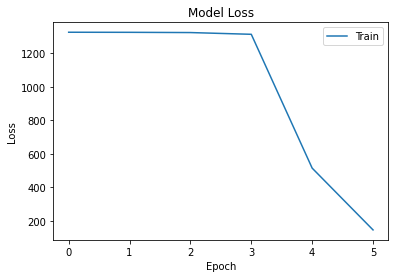

In [96]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()